In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
#### Bank Binary Classification 

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank-classify').getOrCreate()
df = spark.read.csv("bank.csv", header=True, inferSchema=True) # Kaggle Bank Marketing Data: https://www.kaggle.com/rouseguy/bankbalanced/data
df.printSchema() # output: deposit

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [11]:
# summary stastics for numerice variables
import pandas as pd
numeric_features = []
for types in df.dtypes:
  if types[1] == 'int':
    numeric_features.append(types[0]) # append the numerice features

print(numeric_features)
df.select(numeric_features).describe().toPandas().transpose()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [0]:
#numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
#print(numeric_features)
#df.select(numeric_features).describe().toPandas().transpose()

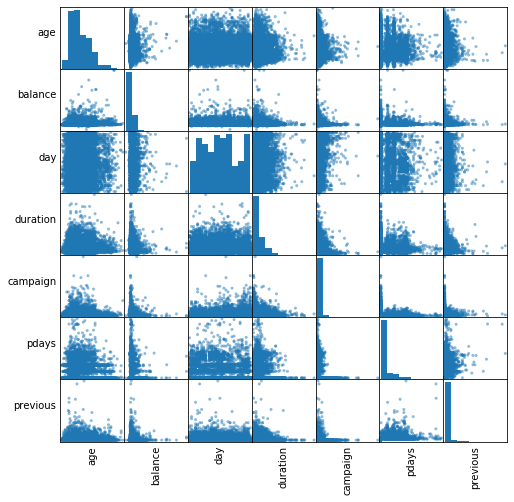

In [13]:
# Correlations between independent variables.
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [14]:
# remove input: day and month
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [0]:
# Data Preprocessing

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [16]:
# Pipeline

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [17]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [18]:
train, test = df.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7797
Test Dataset Count: 3365


In [0]:
# Linear Regression Model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

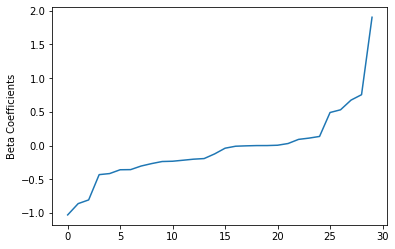

In [20]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

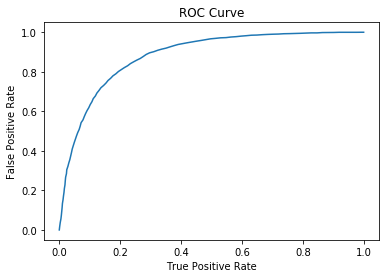

Training set areaUnderROC: 0.8815929117182412


In [21]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

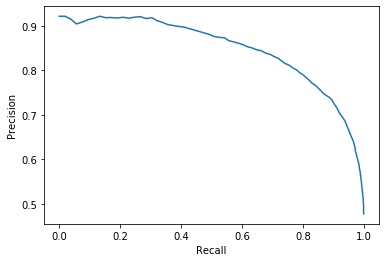

In [22]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [23]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[1.83684017311713...|       0.0|[0.86257457150535...|
| 37|management|  0.0|[1.09545245219006...|       0.0|[0.74940706275753...|
| 52|management|  0.0|[-0.7580329997110...|       1.0|[0.31907347552060...|
| 53|management|  0.0|[0.94350855877318...|       0.0|[0.71980782482734...|
| 57|management|  0.0|[1.16964488183736...|       0.0|[0.76308082045143...|
| 61|management|  0.0|[0.91100869557153...|       0.0|[0.71320652871014...|
| 46|management|  0.0|[2.14433999990620...|       0.0|[0.89513868555609...|
| 36|management|  0.0|[1.05660385286932...|       0.0|[0.74204100243643...|
| 40|management|  0.0|[1.48064527231765...|       0.0|[0.81467002549477...|
| 40|management|  0.0|[1.30280957111630...|       0.0|[0.78630744952447...|
+---+-------

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8948427991670396


In [25]:
# Decision Tree Model
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 35|management|  0.0|[732.0,1082.0]|       1.0|[0.40352811466372...|
| 37|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 52|management|  0.0|[503.0,1936.0]|       1.0|[0.20623206232062...|
| 53|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 57|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 61|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 46|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 36|management|  0.0|  [349.0,21.0]|       0.0|[0.94324324324324...|
| 40|management|  0.0|  [349.0,21.0]|       0.0|[0.94324324324324...|
| 40|management|  0.0|  [349.0,21.0]|       0.0|[0.94324324324324...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [26]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.782761174538419


In [27]:
# Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[12.4525563267205...|       0.0|[0.62262781633602...|
| 37|management|  0.0|[14.0578673417780...|       0.0|[0.70289336708890...|
| 52|management|  0.0|[6.92727399720747...|       1.0|[0.34636369986037...|
| 53|management|  0.0|[13.0155839876057...|       0.0|[0.65077919938028...|
| 57|management|  0.0|[14.0578673417780...|       0.0|[0.70289336708890...|
| 61|management|  0.0|[9.93223459522972...|       1.0|[0.49661172976148...|
| 46|management|  0.0|[14.9232316165933...|       0.0|[0.74616158082966...|
| 36|management|  0.0|[14.6210439487494...|       0.0|[0.73105219743747...|
| 40|management|  0.0|[14.5727542929409...|       0.0|[0.72863771464704...|
| 40|management|  0.0|[14.6210439487494...|       0.0|[0.73105219743747...|
+---+-------

In [28]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8939707032552998


In [29]:
# Gradient-Boosted Tree Classifier
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[0.00523863003964...|       0.0|[0.50261929105925...|
| 37|management|  0.0|[0.45611759846541...|       0.0|[0.71345733533148...|
| 52|management|  0.0|[-0.6139332433376...|       1.0|[0.22655505859473...|
| 53|management|  0.0|[0.03698770815621...|       0.0|[0.51848542493511...|
| 57|management|  0.0|[0.45611759846541...|       0.0|[0.71345733533148...|
| 61|management|  0.0|[-0.3904664207042...|       1.0|[0.31411887221274...|
| 46|management|  0.0|[1.31338130936222...|       0.0|[0.93256424129022...|
| 36|management|  0.0|[0.98079391560200...|       0.0|[0.87670468947647...|
| 40|management|  0.0|[0.76957704719894...|       0.0|[0.82334172179109...|
| 40|management|  0.0|[0.97202467792988...|       0.0|[0.87479633368517...|
+---+-------

In [30]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9037395969515111


In [31]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [32]:
# GBTC parms tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9085021455511194